## Carrega Pacotes

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost
from catboost import Pool
import xgboost
import optuna
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from csv import writer
from csv import reader
import pandas_profiling

/kaggle/input/datasets-28454-184859-consumo-cerveja/datasets_28454_184859_Consumo_cerveja.csv


## Carrega DataSet

In [2]:
df = pd.read_csv('../input/datasets-28454-184859-consumo-cerveja/datasets_28454_184859_Consumo_cerveja.csv', 
                 thousands='.',
                 decimal=',',
                 encoding='utf-8')

## Tratamento DataSet

In [3]:
#Altera nome colunas
df = df.rename(columns={'Temperatura Media (C)':'temp_media', 'Temperatura Minima (C)':'temp_minima', 'Temperatura Maxima (C)':'temp_maxima', 'Precipitacao (mm)':'precipitacao','Final de Semana':'final_semana', 'Consumo de cerveja (litros)':'consumo_cerveja'})
df

,Data,temp_media,temp_minima,temp_maxima,precipitacao,final_semana,consumo_cerveja
0,2015-01-01,27.30,23.9,32.5,0.0,0.0,25461.0
1,2015-01-02,27.02,24.5,33.5,0.0,0.0,28972.0
2,2015-01-03,24.82,22.4,29.9,0.0,1.0,30814.0
3,2015-01-04,23.98,21.5,28.6,1.2,1.0,29799.0
4,2015-01-05,23.82,21.0,28.3,0.0,0.0,28900.0
...,...,...,...,...,...,...,...
936,NaN,NaN,NaN,NaN,NaN,NaN,NaN
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
#Conta quantos valores nulos variavel
totalNulo = df['consumo_cerveja'].isna().sum()
totalNulo = (totalNulo / df.index.size) * 100
totalNulo

61.211477151966

### 61.211% do DataSet possui valores nulos. Estes serão retirados pois, quando encontrados, toda a linha do DataSet está nula, portanto não interferindo nas respostas que pretendemos alcançar. 

In [5]:
#Exclui Nan
df.dropna(inplace=True)

## Criando Features Enginers

In [6]:
# Ajusta data
df['Data'] = pd.to_datetime(df['Data'])

# Numero dia da semana
df['num_dia_semana'] = df['Data'].dt.dayofweek

# Cria coluna dia da semana
df['dia_semana'] = df.Data.dt.day_name()

# Cria coluna mes
df['mes'] = df['Data'].dt.strftime('%m')

In [7]:
# Encontra feriados

import holidays
    
feriados = holidays.Brazil()
    
for feriado in feriados['2015-01-01': '2015-12-31'] :
    print(feriado)


2015-01-01
2015-02-17
2015-02-18
2015-04-03
2015-04-05
2015-04-21
2015-05-01
2015-06-04
2015-09-07
2015-10-12
2015-11-02
2015-11-15
2015-12-25


In [8]:
#Altera tipo dado
#df = df.replace({',': '.'}, regex=True)

#Altera tipo object para float
#df['temp_minima'] = df['temp_minima'].astype(float, errors = 'raise')
#df['temp_media'] = df['temp_media'].astype(float, errors = 'raise')
#df['temp_maxima'] = df['temp_maxima'].astype(float, errors = 'raise')
#df['precipitacao'] = df['precipitacao'].astype(float, errors = 'raise')
df['mes'] = df['mes'].astype(int, errors = 'raise')
df['num_dia_semana'] = df['num_dia_semana'].astype(int, errors= 'raise')

## Análise

In [9]:
#Consumo de Cerveja por dia da semana
dfDiaSemana = df[['dia_semana', 'num_dia_semana', 'consumo_cerveja']].groupby(['dia_semana', 'num_dia_semana']).sum().reset_index()
dfDiaSemana = dfDiaSemana.sort_values('num_dia_semana')
dfDiaSemana

,dia_semana,num_dia_semana,consumo_cerveja
1,Monday,0,1227701.0
5,Tuesday,1,1266468.0
6,Wednesday,2,1238140.0
4,Thursday,3,1276057.0
0,Friday,4,1255170.0
2,Saturday,5,1499572.0
3,Sunday,6,1508391.0


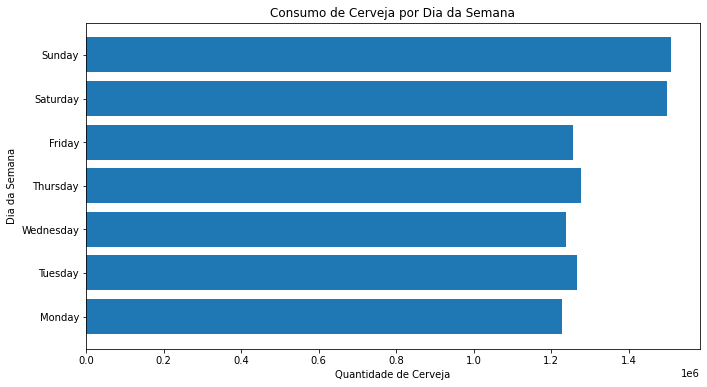

In [10]:
#Gráfico consumo cerveja por dia da semana
plt.figure(figsize=(11,6))
plt.barh(dfDiaSemana.dia_semana, dfDiaSemana.consumo_cerveja)
plt.xlabel('Quantidade de Cerveja')
plt.ylabel('Dia da Semana')
plt.title("Consumo de Cerveja por Dia da Semana")
plt.show()

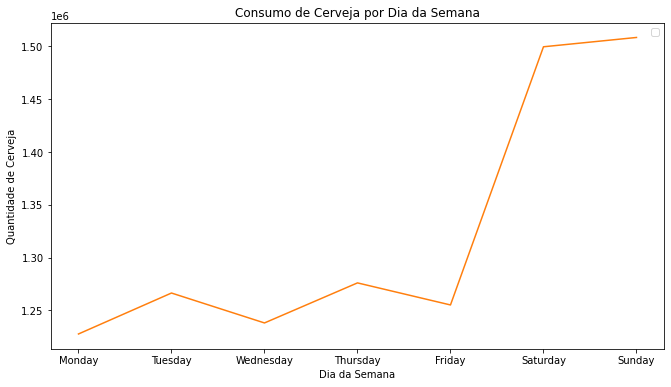

In [11]:
#Grafico de linhas consumo cerveja por dia da semana
plt.figure(figsize=(11,6))
plt.plot(dfDiaSemana.dia_semana.values, dfDiaSemana.consumo_cerveja, color='tab:orange')
plt.title("Consumo de Cerveja por Dia da Semana")
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Cerveja')
plt.legend()
plt.show()

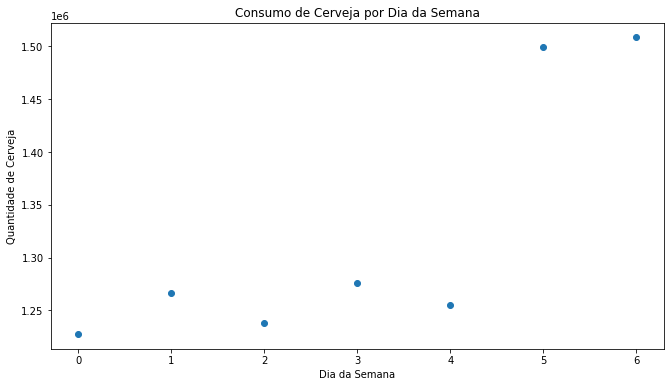

In [12]:
#Dispersão consumo cerveja por dia da semana
plt.figure(figsize=(11,6))
plt.scatter(x=dfDiaSemana.num_dia_semana, y=dfDiaSemana.consumo_cerveja)
plt.xticks(dfDiaSemana.num_dia_semana.values)
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Cerveja')
plt.title("Consumo de Cerveja por Dia da Semana")
plt.show()

In [13]:
#Consumo de cerveja por mes
dfMes = df[['mes', 'consumo_cerveja']].groupby(['mes']).sum().reset_index()
#dfMes = dfMes.sort_values('consumo_cerveja')

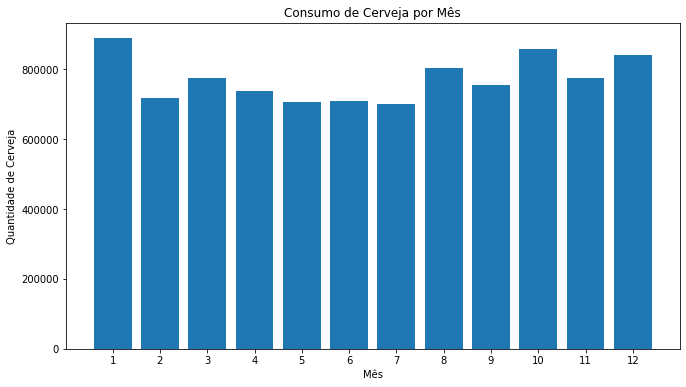

In [14]:
#Grafico consumo cerveja por mes
plt.figure(figsize=(11,6))
plt.bar(dfMes.mes, dfMes.consumo_cerveja)
plt.xticks(dfMes.mes.values)
plt.xlabel('Mês')
plt.ylabel('Quantidade de Cerveja')
plt.title("Consumo de Cerveja por Mês")
plt.show()

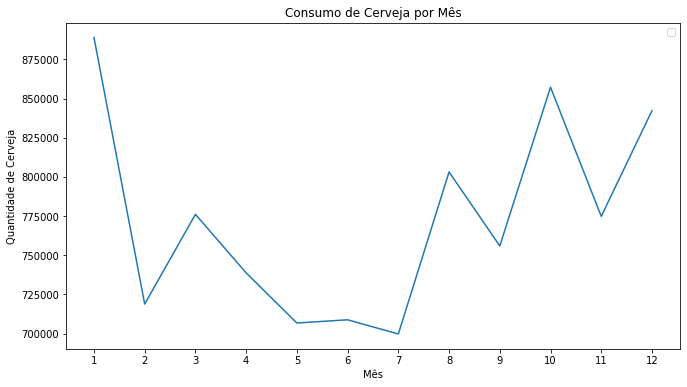

In [15]:
#Grafico consumo de cerveja por mes
plt.figure(figsize=(11,6))
plt.plot(dfMes.mes.values, dfMes.consumo_cerveja, color='tab:blue')
plt.title("Consumo de Cerveja por Mês")
plt.xticks(dfMes.mes.values)
plt.xlabel('Mês')
plt.ylabel('Quantidade de Cerveja')
plt.legend()
plt.show()

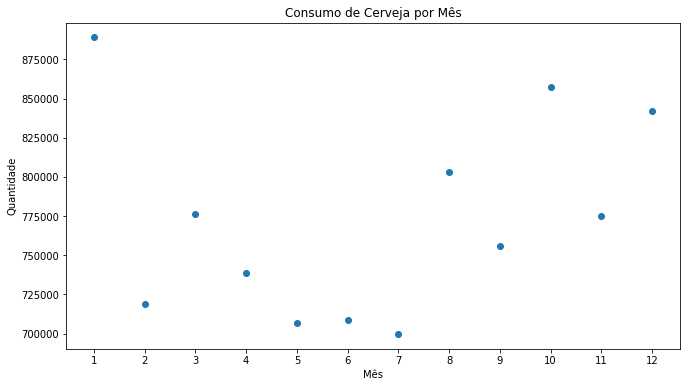

In [16]:
#Dispersão consumo cerveja por dia da semana
plt.figure(figsize=(11,6))
plt.scatter(x=dfMes.mes.values, y=dfMes.consumo_cerveja)
plt.xticks(dfMes.mes.values)
plt.xlabel('Mês')
plt.ylabel('Quantidade')
plt.title('Consumo de Cerveja por Mês')
plt.show()

In [17]:
#Soma acumulada de consumo de cerveja
dfConsumoSoma = (
    df[['Data', 'consumo_cerveja']]
    .assign(Data = lambda x: pd.to_datetime(x.Data,infer_datetime_format=True))
    .sort_values('Data')
)
dfConsumoSoma

,Data,consumo_cerveja
0,2015-01-01,25461.0
1,2015-01-02,28972.0
2,2015-01-03,30814.0
3,2015-01-04,29799.0
4,2015-01-05,28900.0
...,...,...
360,2015-12-27,32307.0
361,2015-12-28,26095.0
362,2015-12-29,22309.0
363,2015-12-30,20467.0


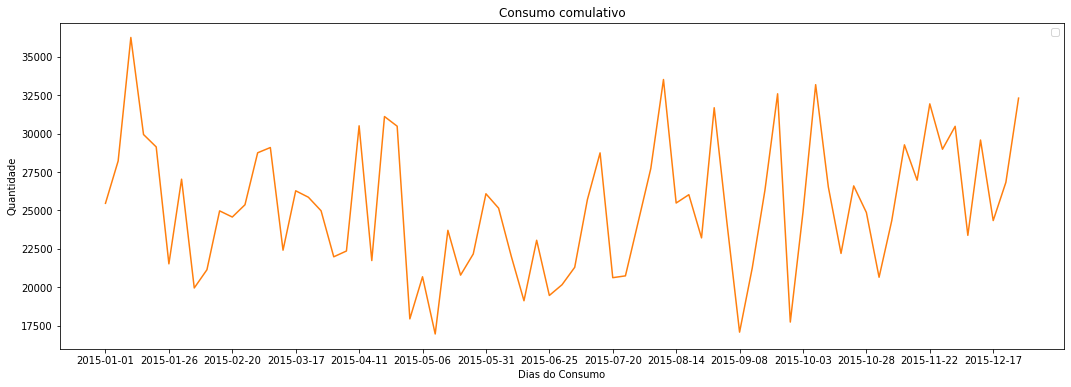

In [18]:
plt.figure(figsize=(18,6))
plt.plot(dfConsumoSoma.Data.loc[::5].values, dfConsumoSoma.consumo_cerveja.loc[::5].values, color='tab:orange')
plt.title("Consumo comulativo")
plt.xticks(dfConsumoSoma.Data.loc[::25].values)
#plt.yticks(dfConsumoSoma.consumo_cerveja[::100].values)
plt.xlabel('Dias do Consumo')
plt.ylabel('Quantidade')
plt.legend()
plt.show()

In [19]:
#Consumo de cerveja dia útil ou não
dfUtil = df[['final_semana', 'consumo_cerveja']].groupby(['final_semana']).sum().reset_index()
dfUtil
#dfMes = dfMes.sort_values('consumo_cerveja')

,final_semana,consumo_cerveja
0,0.0,6263536.0
1,1.0,3007963.0


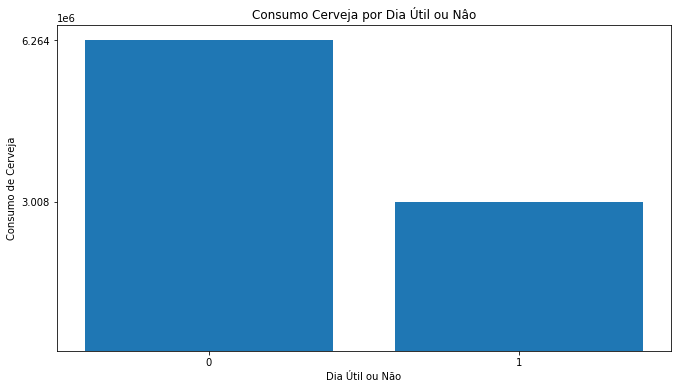

In [20]:
# Gráfico dia util ou não

#Grafico consumo cerveja por mes
plt.figure(figsize=(11,6))
plt.bar(dfUtil.final_semana, dfUtil.consumo_cerveja)
plt.xticks(dfUtil['final_semana'])
plt.yticks(dfUtil['consumo_cerveja'])
plt.xlabel('Dia Útil ou Não')
plt.ylabel('Consumo de Cerveja')
plt.title('Consumo Cerveja por Dia Útil ou Nâo')
plt.show()

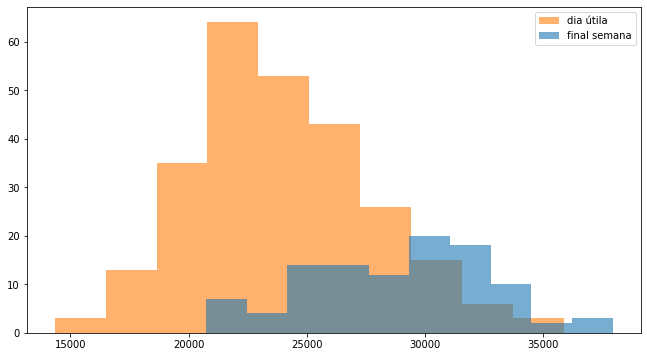

In [21]:
#Histograma final se semana e dia util
plt.figure(figsize=(11,6))
plt.hist(df[df.final_semana == 0.0].consumo_cerveja,alpha=0.6,color='tab:orange',label='dia útila')
plt.hist(df[df.final_semana == 1.0].consumo_cerveja,alpha=0.6,color='tab:blue',label='final semana')
plt.legend()

In [22]:
#Media de consumo de cerveja em dia de temperatura maxima maior que 25º C
df[df['temp_maxima'] > 25].consumo_cerveja.mean()

27084.954356846472

In [23]:
#Media de consumo de cerveja em dia de temperatura minima menor que 25º C
df[df['temp_maxima'] < 25].consumo_cerveja.mean()

22100.338842975205

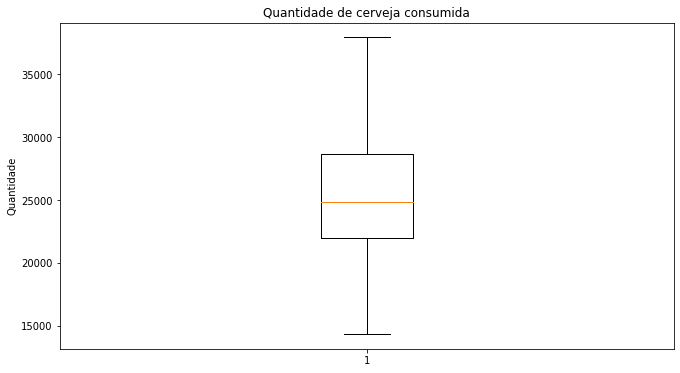

In [24]:
# Verifica outliers consumo cerveja

plt.figure(figsize=(11,6))
plt.boxplot(df.consumo_cerveja)
plt.title('Quantidade de cerveja consumida')
plt.ylabel('Quantidade')
plt.show()

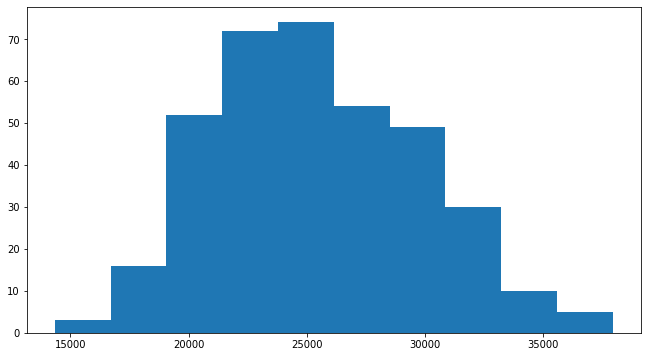

In [25]:
#historgrama consumo cerveja
plt.figure(figsize=(11,6))
plt.hist(df.consumo_cerveja)
plt.show()

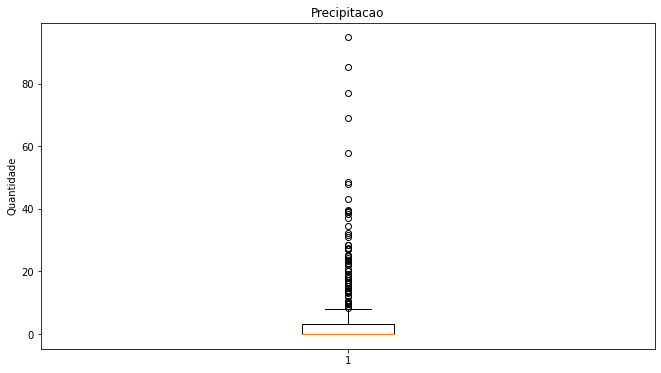

In [26]:
# Verifica outliers precipitacao

plt.figure(figsize=(11,6))
plt.boxplot(df.precipitacao)
plt.title('Precipitacao')
plt.ylabel('Quantidade')
plt.show()

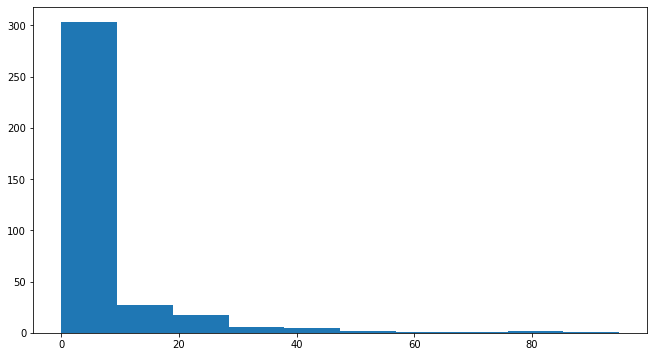

In [27]:
#historgrama precipitacao

plt.figure(figsize=(11,6))
plt.hist(df.precipitacao)
plt.show()

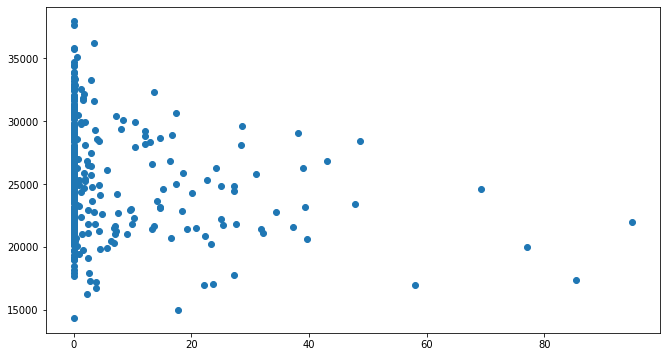

In [28]:
#Dispersão precipitacao e consumo cerveja

plt.figure(figsize=(11,6))
plt.scatter(df.precipitacao, df.consumo_cerveja)
plt.show()

In [29]:
dfP = df[['precipitacao', 'Data']].groupby(['Data']).sum().sort_values('Data')

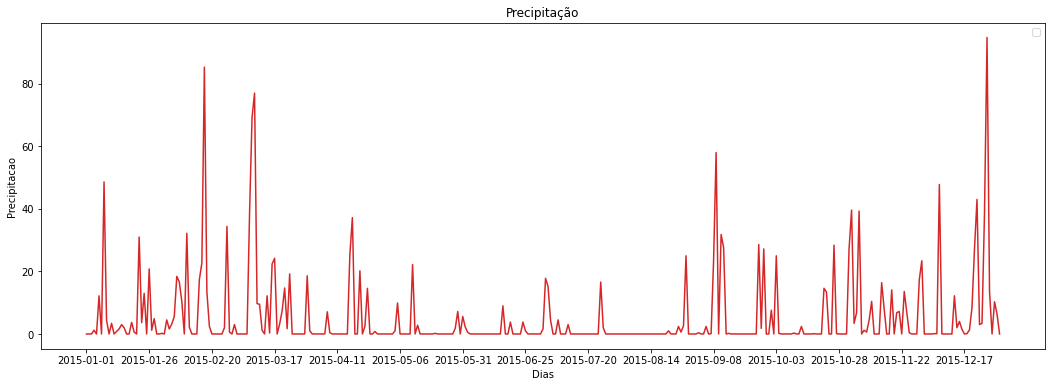

In [30]:
#Grafico precipitacao por dia

plt.figure(figsize=(18,6))
plt.plot(dfP.index.values, dfP.precipitacao.values, color='tab:red')
plt.title("Precipitação")
plt.xticks(dfConsumoSoma.Data.loc[::25].values)
plt.xlabel('Dias')
plt.ylabel('Precipitacao')
plt.legend()
plt.show()

In [31]:
#Retira outliers
iqr = np.quantile(df.precipitacao,0.75) - np.quantile(df.precipitacao,0.25)
upper_bound = np.quantile(df.precipitacao,0.75) + 1.5 * iqr
upper_bound

8.0

In [32]:
def trata_outlier_precipitacao(precipitacao):
    retorno = precipitacao
    if precipitacao > 8:
        return 8
    else:
        return retorno

In [33]:
#insere nova variavel

df['precipitacao_t'] = df.precipitacao.apply(trata_outlier_precipitacao)

In [34]:
#filra dataset com precipitacao menor que 8

df2 = df[df.precipitacao < upper_bound]

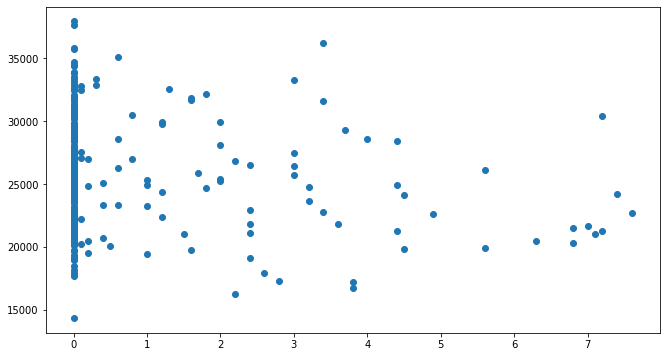

In [35]:
#Dispersão após retirada de outiliers precipitacao

plt.figure(figsize=(11,6))
plt.scatter(df2.precipitacao, df2.consumo_cerveja)
plt.show()

In [36]:
#Correlação
df[['temp_minima', 'temp_media', 
    'temp_maxima', 'precipitacao', 
    'final_semana', 'consumo_cerveja'
]].corr(method='pearson')

,temp_minima,temp_media,temp_maxima,precipitacao,final_semana,consumo_cerveja
temp_minima,1.000000,0.862752,0.672929,0.098625,-0.059534,0.392509
temp_media,0.862752,1.000000,0.922513,0.024416,-0.050803,0.574615
temp_maxima,0.672929,0.922513,1.000000,-0.049305,-0.040258,0.642672
precipitacao,0.098625,0.024416,-0.049305,1.000000,0.001587,-0.193784
final_semana,-0.059534,-0.050803,-0.040258,0.001587,1.000000,0.505981
consumo_cerveja,0.392509,0.574615,0.642672,-0.193784,0.505981,1.000000


In [37]:
#Dropa variáveis para criação de gráficos de dispersão

#df2 = df2.drop(['Data'], axis=1)
df1 = df.drop(['Data', 'mes', 'dia_semana'], axis=1)

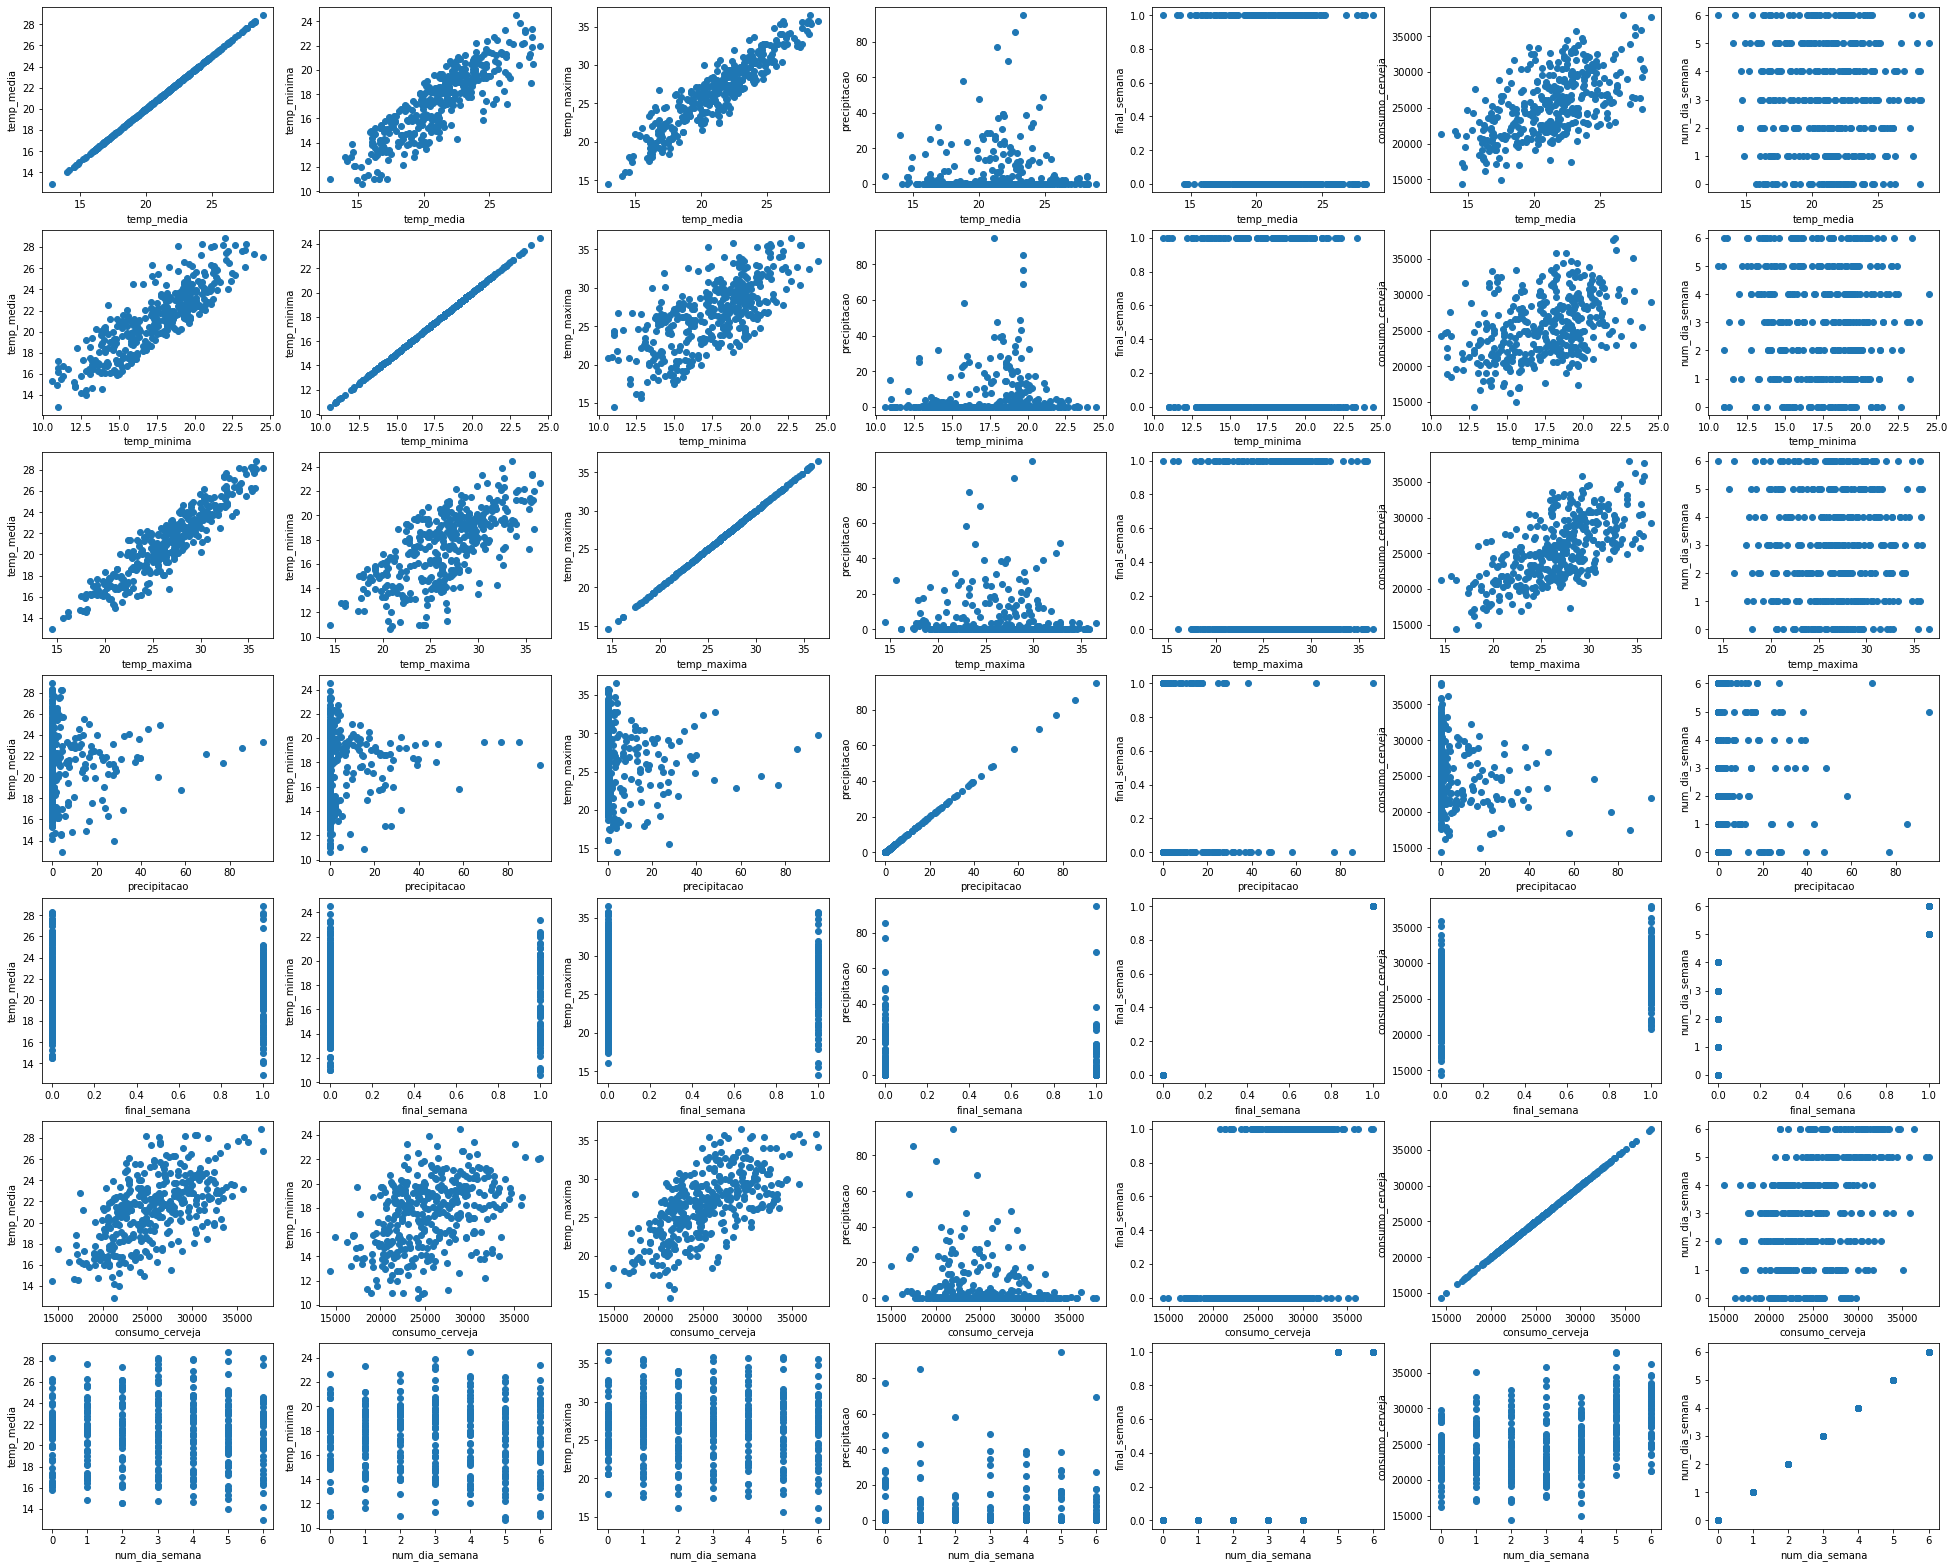

In [38]:
#Graficos de dispersão

f, ax = plt.subplots(7,7,figsize=(34,28))

nome_colunas = df1.columns

for linha in range(7):
    for colunas in range(7):
        
        ax[linha,colunas].scatter(nome_colunas[linha],nome_colunas[colunas],data=df1)
        ax[linha,colunas].set_xlabel(nome_colunas[linha])
        ax[linha,colunas].set_ylabel(nome_colunas[colunas])

<AxesSubplot:>

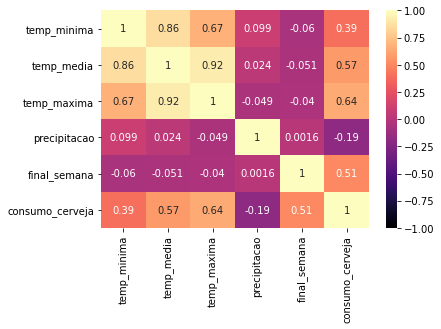

In [39]:
# Grafigo de correlação

import seaborn as sns

sns.heatmap(df[['temp_minima', 'temp_media', 
    'temp_maxima', 'precipitacao', 
    'final_semana', 'consumo_cerveja'
]].corr(),vmin=-1,vmax=1,cmap='magma',annot=True)

In [40]:
dfData = df[['Data', 'consumo_cerveja']].groupby(['Data']).sum()
dfData = dfData.sort_values('Data')
dfData = dfData.reset_index()
dfData['Data']

0     2015-01-01
1     2015-01-02
2     2015-01-03
3     2015-01-04
4     2015-01-05
         ...    
360   2015-12-27
361   2015-12-28
362   2015-12-29
363   2015-12-30
364   2015-12-31
Name: Data, Length: 365, dtype: datetime64[ns]

In [41]:
#Media Consumo cerveja por final de semana
dfFinalSemana = df[['final_semana', 'consumo_cerveja']].groupby(['final_semana']).mean().reset_index()
#dfFinalSemana[['final_semana', 'consumo_cerveja']].corr()
df[['final_semana', 'consumo_cerveja']].corr()

,final_semana,consumo_cerveja
final_semana,1.000000,0.505981
consumo_cerveja,0.505981,1.000000


In [42]:
df[df['final_semana'] == 0.0].consumo_cerveja.mean()
df[df['final_semana'] == 1.0].consumo_cerveja.mean()

28922.721153846152

# Machine Learning

### Nesse trabalho será usado regressão linear multipla, pois sua variável dependente possui um valor continuo. E essa é a principal característica para para a regressão simples.

### Nesse primeiro exemplo, irei realizar a Regressão Linear e a Árvore de Decisão utilizando a variável target consumo da cerveja e as variáveis independentes precipitação, temperatura média e dia útil ou não. 

In [43]:
dfr = df.drop(['Data', 'temp_maxima', 'temp_minima', 'num_dia_semana', 'dia_semana', 'mes', 'precipitacao_t'], axis=1)

In [44]:
x,y = dfr.drop(['consumo_cerveja'], axis=1), dfr.consumo_cerveja

In [45]:
## Separa treino teste

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=37)
x_train.shape,y_train.shape

((273, 3), (273,))

In [46]:
#Modelo de Regressão linear Multipla
lr = LinearRegression(n_jobs=-1)
lr.fit(x_train, y_train)

LinearRegression(n_jobs=-1)

In [47]:
#Coeficiente

lr.coef_

array([ 863.11449875,  -67.32547588, 5256.84274908])

In [48]:
#Intercepto

lr.intercept_

6031.394109958834

In [49]:
#Avaliação Metricas para teste

y_pred_teste = lr.predict(x_test)

print('MSE : ',mean_squared_error(y_test,y_pred_teste))
print('RMSE : ', mean_squared_error(y_test,y_pred_teste)**0.5)

MSE :  6351473.3317598
RMSE :  2520.2129536528855


In [50]:
#Avaliação Metricas para treino

y_pred_treino = lr.predict(x_train)

print('MSE : ',mean_squared_error(y_train,y_pred_treino))
print('RMSE : ', mean_squared_error(y_train,y_pred_treino)**0.5)

MSE :  6632942.862933743
RMSE :  2575.4500311467395


### Podemos observar que não há overfit, pois visualizando as nossas métricas de erros não demostram um diferença muito grande entre teste e treino.

In [51]:
## R2

r2_score(y_test, y_pred_teste)

0.6777344688278677

### R2 informa que poderemos utilizar 0.67 % dos nossos dados

In [52]:
dc_data = {}

for i in range(10,50,5):
    test_size = i/100
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=37)
    
    lr = LinearRegression(n_jobs=-1)
    lr.fit(x_train,y_train)
    
    dc_data[test_size] = [mean_squared_error(y_test,lr.predict(x_test)), 
                          mean_squared_error(y_train,lr.predict(x_train)),
                          r2_score(y_test,lr.predict(x_test))]

In [53]:
dc_data
[x[0] for x in dc_data.values()]
[x[1] for x in dc_data.values()]

[6395507.285617634,
 6479217.442561205,
 6560114.541627176,
 6632942.862933743,
 6607949.03570209,
 6579013.2993507385,
 6662728.134905488,
 6514351.082163091]

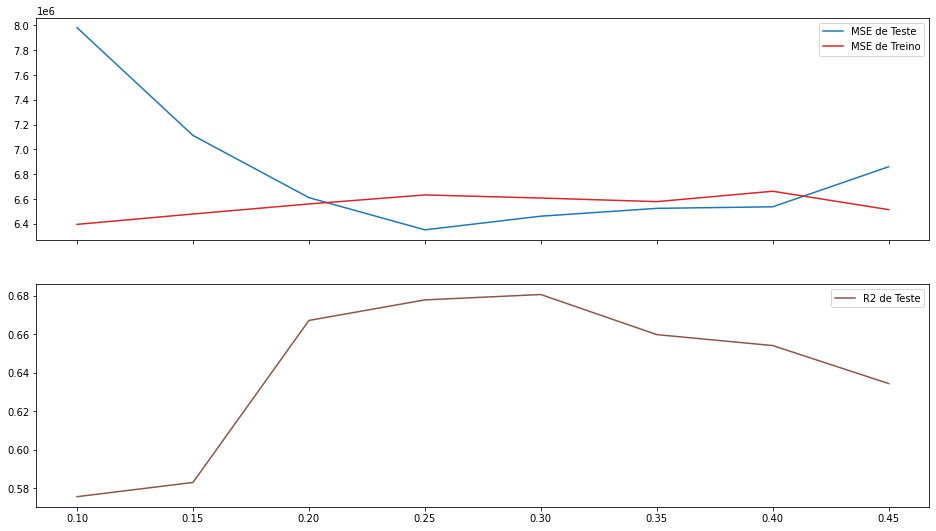

In [54]:
#Gráfico metricas de erros

f, ax = plt.subplots(2,1, sharex=True, figsize=(16,9))

ax[0].plot(dc_data.keys(),[x[0] for x in dc_data.values()], color='tab:blue', label='MSE de Teste')
ax[0].plot(dc_data.keys(),[x[1] for x in dc_data.values()], color='tab:red', label='MSE de Treino')
ax[0].legend()

ax[1].plot(dc_data.keys(),[x[2] for x in dc_data.values()], color='tab:brown', label='R2 de Teste')
ax[1].set_xticks(list(dc_data.keys()))
ax[1].legend()
                 
plt.legend()

In [55]:
# Compara os modelos

def avalia_modelo(modelo1,modelo2,x,y):
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=37)    
    ## Treinando modelo 1
    
    modelo1.fit(x_train, y_train)
    
    ## Treinando modelo 2
    
    modelo2.fit(x_train,y_train)
    
    ## Avalia os modeos
    
    mse = []
    r2 = []
    
    mse.append(mean_squared_error(y_test, modelo1.predict(x_test)))
    mse.append(mean_squared_error(y_test, modelo2.predict(x_test)))
    
    r2.append(r2_score(y_test, modelo1.predict(x_test)))
    r2.append(r2_score(y_test, modelo2.predict(x_test)))
    
    dfResult = pd.DataFrame([mse,r2], columns=['Modelo1','Modelo2'],index=['mse','r2'])
    
    return dfResult, modelo1, modelo2

In [56]:
lr = LinearRegression()
dt = DecisionTreeRegressor(min_samples_leaf=10, random_state=991151575)

In [57]:
dfResult, modelo1, modelo2 = avalia_modelo(lr,dt,x,y)

In [58]:
dfResult

,Modelo1,Modelo2
mse,6.351473e+06,8.496789e+06
r2,6.777345e-01,5.688839e-01


In [59]:
modelo1.coef_

array([ 863.11449875,  -67.32547588, 5256.84274908])

### Nesse exemplo, irei realizar a Regressão Linear e a Árvore de Decisão utilizando a variável target consumo da cerveja e as variáveis independentes precipitação, temperatura máxima e dia útil ou não.

In [60]:
dfr1 = df.drop(['Data', 'temp_media', 'temp_minima', 'num_dia_semana', 'dia_semana', 'mes', 'precipitacao_t'], axis=1)

In [61]:
x1,y1 = dfr1.drop(['consumo_cerveja'], axis=1), dfr1.consumo_cerveja

In [62]:
# Separa treino teste

x_train1,x_test1,y_train1,y_test1 = train_test_split(x1,y1,test_size=0.25,random_state=37)
x_train1.shape,y_train1.shape

((273, 3), (273,))

In [63]:
#Modelo de Regressão linear
lrm = LinearRegression(n_jobs=-1)
lrm.fit(x_train1, y_train1)

LinearRegression(n_jobs=-1)

In [64]:
#Coeficiente

lrm.coef_

array([ 695.80353217,  -47.78839472, 5157.97761925])

In [65]:
#Intercepto

lrm.intercept_

5772.163543476574

In [66]:
#Avaliação Metricas para teste

y_pred_teste_m = lrm.predict(x_test1)

print('MSE : ',mean_squared_error(y_test1,y_pred_teste_m))
print('RMSE : ', mean_squared_error(y_test1,y_pred_teste_m)**0.5)

MSE :  5414465.696175365
RMSE :  2326.900448273489


In [67]:
#Avaliação Metricas para treino

y_pred_treino_m = lrm.predict(x_train1)

print('MSE : ',mean_squared_error(y_train1,y_pred_treino_m))
print('RMSE : ', mean_squared_error(y_train1,y_pred_treino_m)**0.5)

MSE :  5384529.298788462
RMSE :  2320.458855224212


### Podemos observar que não há overfit, pois visualizando as nossas métricas de erros não demostram um diferença muito grande entre teste e treino.

In [68]:
# R2

r2_score(y_test1, y_pred_teste_m)

0.7252770227553194

### R2 informa que poderemos utilizar 0.72 % dos nossos dados

In [69]:
dc_data_m = {}

for i in range(10,50,5):
    test_size = i/100
    x_train1,x_test1,y_train1,y_test1 = train_test_split(x1,y1,test_size=test_size,random_state=37)
    
    lrm = LinearRegression(n_jobs=-1)
    lrm.fit(x_train1,y_train1)
    
    dc_data_m[test_size] = [mean_squared_error(y_test1,lrm.predict(x_test1)), 
                          mean_squared_error(y_train1,lrm.predict(x_train1)),
                          r2_score(y_test1,lrm.predict(x_test1))]

In [70]:
dc_data_m
[x[0] for x in dc_data_m.values()]
[x[1] for x in dc_data_m.values()]

[5196439.039020958,
 5248738.074842289,
 5360652.691372802,
 5384529.298788462,
 5370681.650325182,
 5442857.110101646,
 5473783.877023547,
 5270335.538481521]

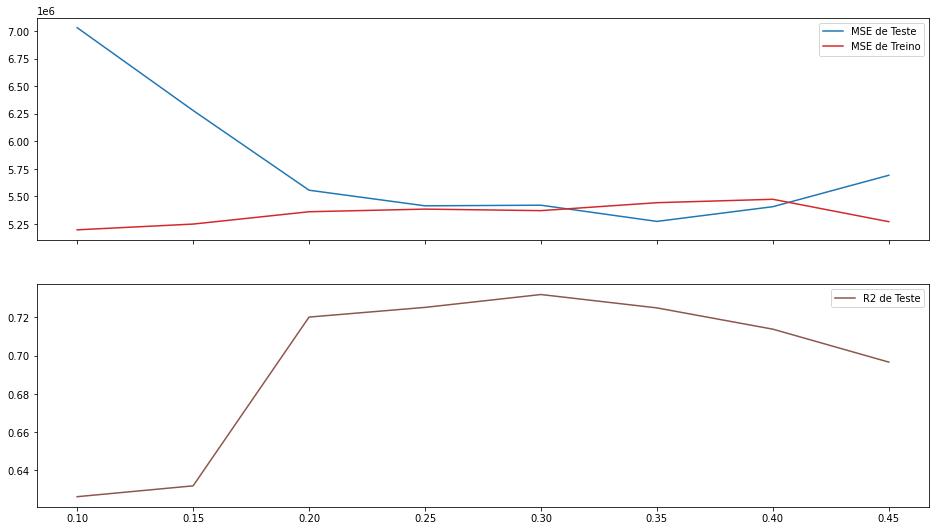

In [71]:
f, ax = plt.subplots(2,1, sharex=True, figsize=(16,9))

ax[0].plot(dc_data_m.keys(),[x[0] for x in dc_data_m.values()], color='tab:blue', label='MSE de Teste')
ax[0].plot(dc_data_m.keys(),[x[1] for x in dc_data_m.values()], color='tab:red', label='MSE de Treino')
ax[0].legend()

ax[1].plot(dc_data_m.keys(),[x[2] for x in dc_data_m.values()], color='tab:brown', label='R2 de Teste')
ax[1].set_xticks(list(dc_data_m.keys()))
ax[1].legend()
                 
plt.legend()

In [72]:
#Função avalia dois modelos usando Regressão e Árvore

def avalia_modelo1(modelo1,modelo2,x1,y1):
    x_train1,x_test1,y_train1,y_test1 = train_test_split(x1,y1,test_size=0.25,random_state=37)    
    ## Treinando modelo 1
    
    modelo1.fit(x_train1, y_train1)
    
    ## Treinando modelo 2
    
    modelo2.fit(x_train1,y_train1)
    
    ## Avalia os modeos
    
    mse = []
    r2 = []
    
    mse.append(mean_squared_error(y_test1, modelo1.predict(x_test1)))
    mse.append(mean_squared_error(y_test1, modelo2.predict(x_test1)))
    
    r2.append(r2_score(y_test1, modelo1.predict(x_test1)))
    r2.append(r2_score(y_test1, modelo2.predict(x_test1)))
    
    dfResult = pd.DataFrame([mse,r2], columns=['Modelo1','Modelo2'],index=['mse','r2'])
    
    return dfResult, modelo1, modelo2

In [73]:
#Modelos

lr1 = LinearRegression()
dt1 = DecisionTreeRegressor(min_samples_leaf=10, random_state=991151575)

In [74]:
dfResult, modelo1, modelo2 = avalia_modelo(lrm,dt1,x1,y1)

In [75]:
dfResult

,Modelo1,Modelo2
mse,5.414466e+06,7.763895e+06
r2,7.252770e-01,6.060700e-01


In [76]:
modelo1.coef_

array([ 695.80353217,  -47.78839472, 5157.97761925])

### Podemos observar que utilizando a variável independente temperatura máxima, o modelo ficou um pouco melhor que utilizando a temperatura média, pois temos um r2 de 0.72, maior que o retornado no primeiro modelo, 0.67. As métricas de erros também ficaram melhor, porém bem pouco. Isso se dá pelo fato da correlação da temperatura máxima ser melhor com o consumo da cerveja, do que a temperatura média com o consumo de cerveja.

### Nesse exemplo, irei realizar a Regressão Linear e a Árvore de Decisão utilizando a variável target consumo da cerveja e as variáveis independentes precipitação, temperatura máxima e dia útil ou não. Porém, vou calcular o irq da variável precipitacão e retirar os outiliers

In [77]:
dfr2 = df2.drop(['Data', 'temp_media', 'temp_minima', 'num_dia_semana', 'dia_semana', 'mes'], axis=1)

In [78]:
x2,y2 = dfr2.drop(['consumo_cerveja'], axis=1), dfr2.consumo_cerveja

In [79]:
## Separa treino teste

x_train2,x_test2,y_train2,y_test2 = train_test_split(x2,y2,test_size=0.25,random_state=37)
x_train2.shape,y_train2.shape

((225, 4), (225,))

In [80]:
#Modelo de Regressão linear
lrd = LinearRegression(n_jobs=-1)
lrd.fit(x_train2, y_train2)

LinearRegression(n_jobs=-1)

In [81]:
#Coeficiente

lrd.coef_

array([ 680.9427293 ,  -36.16046977, 5559.04467635,  -36.16046977])

In [82]:
#Intercepto

lrd.intercept_

5934.255599907105

In [83]:
#Avaliação Metricas para teste

y_pred_teste_d = lrd.predict(x_test2)

print('MSE : ',mean_squared_error(y_test2,y_pred_teste_d))
print('RMSE : ', mean_squared_error(y_test2,y_pred_teste_d)**0.5)

MSE :  5383541.527496403
RMSE :  2320.2460058141255


In [84]:
#Avaliação Metricas para treino

y_pred_treino_d = lrd.predict(x_train2)

print('MSE : ',mean_squared_error(y_train2,y_pred_treino_d))
print('RMSE : ', mean_squared_error(y_train2,y_pred_treino_d)**0.5)

MSE :  5401958.972809717
RMSE :  2324.2114733409517


### Podemos observar que não há overfit, pois visualizando as nossas métricas de erros não demostram um diferença muito grande entre teste e treino.

In [85]:
## R2

r2_score(y_test2, y_pred_teste_d)

0.6988674440744471

### Observamos que existe uma munça no r2, de 0.72 para 0.69, acredito que tal fato seja por perdemos algumas linhas no dataset quando retiramos os outiliers. As métricas tiveram alterações, porém bem pequenas.

In [86]:
#Dados das métricas

dc_data_d = {}

for i in range(10,50,5):
    test_size = i/100
    x_train2,x_test2,y_train2,y_test2 = train_test_split(x2,y2,test_size=test_size,random_state=37)
    
    lrd = LinearRegression(n_jobs=-1)
    lrd.fit(x_train2,y_train2)
    
    dc_data_d[test_size] = [mean_squared_error(y_test2,lrd.predict(x_test2)), 
                          mean_squared_error(y_train2,lrd.predict(x_train2)),
                          r2_score(y_test2,lrd.predict(x_test2))]

In [87]:
dc_data_d
[x[0] for x in dc_data_d.values()]
[x[1] for x in dc_data_d.values()]

[5484612.151941029,
 5508954.364959309,
 5530320.14498864,
 5401958.972809717,
 5573679.588236416,
 5669960.746375908,
 5707239.846229318,
 5678852.8669967335]

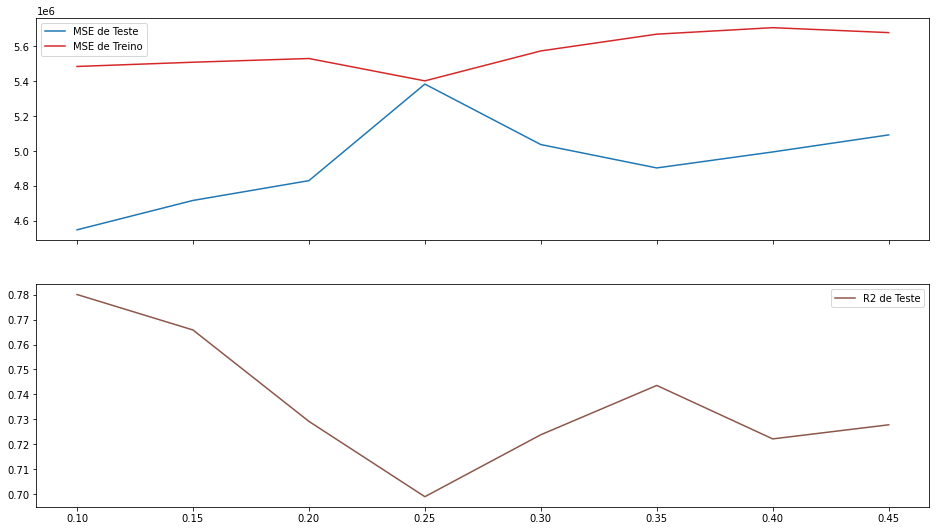

In [88]:
f, ax = plt.subplots(2,1, sharex=True, figsize=(16,9))

ax[0].plot(dc_data_d.keys(),[x[0] for x in dc_data_d.values()], color='tab:blue', label='MSE de Teste')
ax[0].plot(dc_data_d.keys(),[x[1] for x in dc_data_d.values()], color='tab:red', label='MSE de Treino')
ax[0].legend()

ax[1].plot(dc_data_d.keys(),[x[2] for x in dc_data_d.values()], color='tab:brown', label='R2 de Teste')
ax[1].set_xticks(list(dc_data_d.keys()))
ax[1].legend()
                 
plt.legend()

In [89]:
#Função avalia dois modelos usando Regressão e Árvore

def avalia_modelo2(modelo1,modelo2,x2,y2):
    x_train2,x_test2,y_train2,y_test2 = train_test_split(x2,y2,test_size=0.25,random_state=37)    
    ## Treinando modelo 1
    
    modelo1.fit(x_train2, y_train2)
    
    ## Treinando modelo 2
    
    modelo2.fit(x_train2,y_train2)
    
    ## Avalia os modeos
    
    mse = []
    r2 = []
    
    mse.append(mean_squared_error(y_test2, modelo1.predict(x_test2)))
    mse.append(mean_squared_error(y_test2, modelo2.predict(x_test2)))
    
    r2.append(r2_score(y_test2, modelo1.predict(x_test2)))
    r2.append(r2_score(y_test2, modelo2.predict(x_test2)))
    
    dfResult = pd.DataFrame([mse,r2], columns=['Modelo1','Modelo2'],index=['mse','r2'])
    
    return dfResult, modelo1, modelo2

In [90]:
#Modelos

lr2 = LinearRegression()
dt2 = DecisionTreeRegressor(min_samples_leaf=10, random_state=991151575)

In [91]:
dfResult, modelo1, modelo2 = avalia_modelo(lr2, dt2, x2, y2)

In [92]:
dfResult

,Modelo1,Modelo2
mse,5.383542e+06,6.717985e+06
r2,6.988674e-01,6.242243e-01


In [93]:
modelo1.coef_

array([ 680.9427293 ,  -36.16046977, 5559.04467635,  -36.16046977])

### Neste Exemplo, irei utilizar as mesmas variáveis que no exemplo anterior, com exceção da variável de precipitacao, nesse, irei usar a variável precipitacao_t, nela substituir todas as precipitações acima de 8 por 8.

In [94]:
dfr3 = df.drop(['Data', 'temp_media', 'temp_minima', 'num_dia_semana', 'dia_semana', 'mes', 'precipitacao'], axis=1)

In [95]:
x3,y3 = dfr3.drop(['consumo_cerveja'], axis=1), dfr3.consumo_cerveja

In [96]:
## Separa treino teste

x_train3,x_test3,y_train3,y_test3 = train_test_split(x3,y3,test_size=0.25,random_state=37)
x_train3.shape,y_train3.shape

((273, 3), (273,))

In [97]:
#Modelo de Regressão linear
lrp = LinearRegression(n_jobs=-1)
lrp.fit(x_train3, y_train3)

LinearRegression(n_jobs=-1)

In [98]:
#Avaliação Metricas para teste

y_pred_teste_p = lrd.predict(x_test3)

print('MSE : ',mean_squared_error(y_test3,y_pred_teste_p))
print('RMSE : ', mean_squared_error(y_test3,y_pred_teste_p)**0.5)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

In [99]:
#Avaliação Metricas para treino

y_pred_treino_p = lrd.predict(x_train3)

print('MSE : ',mean_squared_error(y_train3,y_pred_treino_p))
print('RMSE : ', mean_squared_error(y_train3,y_pred_treino_p)**0.5)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 4 is different from 3)

In [100]:
## R2

r2_score(y_test3, y_pred_teste_p)

NameError: name 'y_pred_teste_p' is not defined

### Dessa forma, observamos que as métricas de erros ficaram muito altas e o R2 ficou negativo, portanto, não é um bom modelo.

In [101]:
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [102]:
dt = DecisionTreeRegressor(max_depth=3,min_samples_leaf=10)
svr = SVR()
mlp = MLPRegressor()

In [103]:
dt.fit(x_train,y_train)
svr.fit(x_train,y_train)
mlp.fit(x_train,y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor()

In [104]:
mean_squared_error(y_test,dt.predict(x_test))

10286636.23690432

In [105]:
mean_squared_error(y_test,svr.predict(x_test))

18964344.93514898

In [106]:
mean_squared_error(y_test,mlp.predict(x_test))

636229264.6787163

In [107]:
mean_squared_error(y_test,lr.predict(x_test))

6564691.895404263

### Concluo que  o melhor modelo para se trabalhar seria utilizando a variável dependente consumo de cerveja e as variáveis independentes temperatura máxima, precipitação e dia útil ou não, pois, observamos que o R2 ficou maior e as metricas de erro menores, mesmo essa tendo uma pouca diferença.